# Gender Classifier

### Load Data

In [97]:
%store -r cnn_model

dataset = cnn_model['dataset']

abstracts_padded = cnn_model['abstracts_padded']
label_map, ys = cnn_model['label_map'], cnn_model['ys']
labels = [i for gender, i in label_map.items()]
num_classes = cnn_model['num_classes']

embeddings = cnn_model['embeddings']
word_dim = cnn_model['word_dim']
word2idx, idx2word = cnn_model['word2idx'], cnn_model['idx2word']
maxlen = cnn_model['maxlen']
vocab_size = cnn_model['vocab_size']
num_train = cnn_model['num_train']

### Train - Validation Split

In [68]:
from sklearn.cross_validation import KFold

fold = KFold(len(abstracts_padded), n_folds=5, shuffle=True)
p = iter(fold)

train_idxs, val_idxs = next(p)

X_train, ys_train = abstracts_padded[train_idxs], ys[train_idxs]
X_val, ys_val = abstracts_padded[val_idxs], ys[val_idxs]

num_train, num_val = len(X_train), len(X_val)

### Hyperparameters

In [69]:
nb_filter = 10
filter_length = 2
hidden_dims = 32
nb_epoch = 35

### Define Model

In [70]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=word_dim, weights=[embeddings], input_length=maxlen,
                   trainable=False))
model.add(Dropout(0.25))

model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        activation='relu'))
model.add(MaxPooling1D(pool_length=maxlen-1)) # non-maximum suppression

model.add(Flatten())
model.add(Dense(hidden_dims))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.layers[3].input_shape # ensure non-maximum suppression

(None, 487, 10)

### Random Balanced Minibatch Generator

In [88]:
def labelidx_generator(ys):
    """Generate a dict of labels to their indices"""

    for label in labels:
        idxs = np.argwhere(ys == label).flatten()
        yield (label, idxs)

def batch_generator(ys, batch_size, balanced=True):
    """Yield successive batches for training
    
    This generator is not meant to be exhausted, but rather called by next().
    
    Each batch has batch_size/num_classes number of examples from each class
    
    """
    assert not batch_size % num_classes
    
    labels_idxs = dict(labelidx_generator(ys))
    
    while True:
        idxs_lists = [np.random.choice(label_idxs, size=batch_size/num_classes) for label, label_idxs in labels_idxs.items()]
        idxs = [idx for idxs_list in idxs_lists for idx in idxs_list] # flatten list
        
        yield idxs

### Minibatch Training

In [84]:
batch_size = 33

example = batch_generator(ys_train, batch_size)

In [91]:
for i in range(100):
    batch = next(example)
    
    X = X_train[batch]
    ys = np.zeros([batch_size, num_classes])
    ys[np.arange(batch_size), ys_train[batch]] = 1

    print model.train_on_batch(X, ys)
    
    if not i % 10:
        predictions = model.predict(X_val)

        ysval_block = np.zeros([num_val, num_classes])
        ysval_block[np.arange(num_val), ys_val] = 1

        print 'Validation accuracy', np.mean(predictions.argmax(axis=1) == ys_val)

[array(0.8047752380371094, dtype=float32)]
Validation accuracy 0.6
[array(0.8439961671829224, dtype=float32)]
[array(0.7106217741966248, dtype=float32)]
[array(0.7445381879806519, dtype=float32)]
[array(0.7547301054000854, dtype=float32)]
[array(0.7134566903114319, dtype=float32)]
[array(0.7483267784118652, dtype=float32)]
[array(0.7668272256851196, dtype=float32)]
[array(0.7335414290428162, dtype=float32)]
[array(0.719879686832428, dtype=float32)]
[array(0.7679944038391113, dtype=float32)]
Validation accuracy 0.633333333333
[array(0.7509118914604187, dtype=float32)]
[array(0.676609456539154, dtype=float32)]
[array(0.6686001420021057, dtype=float32)]
[array(0.7070923447608948, dtype=float32)]
[array(0.763827919960022, dtype=float32)]
[array(0.6709403395652771, dtype=float32)]
[array(0.7338182330131531, dtype=float32)]
[array(0.7468081116676331, dtype=float32)]
[array(0.7250101566314697, dtype=float32)]
[array(0.7146375775337219, dtype=float32)]
Validation accuracy 0.6
[array(0.67884612

### Confusion Matrix

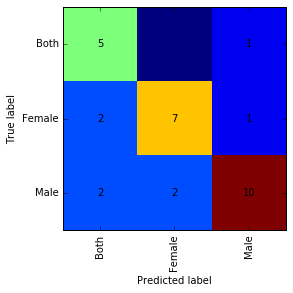

In [92]:
predictions = model.predict(X_val)

ysval_block = np.zeros([num_val, num_classes])
ysval_block[np.arange(num_val), ys_val] = 1

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ys_val, predictions.argmax(axis=1))

from support import plot_confusion_matrix

plot_confusion_matrix(cm, label_map)

### Examine Bigrams Which Filters Fire on

In [125]:
dataset.abstract.iloc[0]

'D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. \n                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. \n                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. \n                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo treatment on any primary outcome

In [130]:
filters = model.layers[2].W.eval()
filters = np.squeeze(filters)
filters = [filter.T for filter in filters]

def activation_generator(filter, abstract):
    for w1, w2 in zip(abstract, abstract[1:]):
        yield np.sum(embeddings[[w1, w2]] * filter), (w1, w2)
        
def activations_generator(filters, abstract):
    for filter in filters:
        yield list(activation_generator(filter, abstract))
        
def show_activations(filters, abstract):        
    activations = list(activations_generator(filters, abstract))

    for activation in activations:
        for score, (w1, w2) in sorted(activation, reverse=True)[:10]:
            print score, idx2word[w1], idx2word[w2]

        print
        
for gender, idx in zip(['Both', 'Female', 'Male'], [0, 50, 100]):
    print '*'*10, gender, '*'*10
    show_activations(filters, abstracts_padded[idx])

********** Both **********
0.682580284712 may be
0.455139355498 D-cycloserine is
0.358263281175 possibly reflecting
0.332385171115 reflecting the
0.323503592954 the N-methyl-D-aspartate
0.311441936647 strongest evidence
0.288976079914 in a
0.288976079914 in a
0.268276217463 in this
0.267926909413 the 6-month

0.290560964054 patients with
0.2895958744 augmentation of
0.242680950261 loss of
0.215280116817 weeks duration
0.184264144981 any primary
0.180453482067 subjects completed
0.16669675686 high drop-out
0.163752142039 drop-out rates
0.161911823728 correlate with
0.147880670635 drop-out rate

0.841647503351 for 6
0.794228559572 at 8
0.7294093399 of 8
0.654612362823 or 24
0.376032314638 24 weeks
0.353352431588 8 weeks
0.323700663088 efficacy over
0.321491230391 D-cycloserine at
0.297801809103 measure at
0.287726979601 agonist at

0.306370556418 cognitive impairment
0.296201840438 a cognitive
0.216173065762 Fifty-five schizophrenia
0.210686960461 Serum D-cycloserine
0.209224780346 cogni